In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

In [3]:
clinical_data_csv = pd.read_csv('Z:\covlus_bmicnas02\clincal_data.csv')
# raw_data_csv = pd.read_csv('Z:\covlus_bmicnas02\\raw\COVID-19_Lung_Ultrasound_Study_M_csv_export_20220530170719\COVID-19_Lung_Ultrasound_Study_M_export_20220530.csv', delimiter=";" 
# )
clinical_data_csv

,Castor ID,Video ID,Number of video files,Video path,Record Id,Record Creation Date,pat_ID,adm_date,incl_crit#fever_or_chills,incl_crit#cough,...,oxygen_other_appl_2,start_oxy_2,end_oxy_2,duration_oxy_2,add_remarks,pos_bp,sys_bp,dias_bp,datetime_bp,report_date_bp
0,120002.0,A001,6.0,147442324278543_A001__2021-02-01,120002,23-02-2021 11:12:51,1.0,01-02-2021,1,1,...,NaN,NaN,NaN,NaN,NaN,1.0,142.0,59.0,01-02-2021 13:30,23-02-2021 11:22:12
1,120003.0,A002,6.0,155966404575240_A002 __2021-02-05,120003,25-02-2021 14:07:03,2.0,05-02-2021,0,1,...,NaN,NaN,NaN,NaN,"1L, mostly during the night due to OSAS, readm...",1.0,156.0,83.0,05-02-2021 10:00,25-02-2021 14:30:44
2,120004.0,A003,6.0,157442132802802_A003__2021-02-05,120004,25-02-2021 14:46:32,3.0,18-01-2021,0,0,...,NaN,19-01-2021,28-01-2021,9.0,28-01-2021 tot 29-01-2021 optiflow / 29-01-202...,1.0,120.0,NaN,NaN,25-02-2021 15:09:36
3,120005.0,A004,6.0,2475457789106_A004__2021-02-08,120005,25-02-2021 15:28:02,4.0,08-02-2021,0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,135.0,77.0,08-02-2021 11:00,25-02-2021 15:42:17
4,120006.0,A005,6.0,3690551939423_A005__2021-02-08,120006,01-03-2021 13:51:23,5.0,08-02-2021,0,0,...,NaN,NaN,NaN,NaN,NaN,1.0,149.0,91.0,08-02-2021 10:55,01-03-2021 14:07:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,120066.0,B018,7.0,10202823093242_B018__2021-04-22,120066,24-06-2021 15:40:21,65.0,21-04-2021,0,1,...,NaN,22-04-2021,24-04-2021,NaN,24-04-2021 until 25-04-2021 oxygen goggles,1.0,118.0,77.0,22-04-2021 23:22,25-03-2022 11:18:33
65,120067.0,B019,6.0,708089780873_B019__2021-05-07,120067,24-06-2021 15:45:58,66.0,07-05-2021,0,1,...,NaN,NaN,NaN,NaN,NaN,1.0,104.0,89.0,07-05-2021 12:23,25-03-2022 13:37:58
66,120068.0,B020,6.0,3659360832248_B020__2021-05-07,120068,24-06-2021 15:55:17,67.0,07-05-2021,0,1,...,NaN,NaN,NaN,NaN,NaN,1.0,140.0,91.0,07-05-2021 16:23,25-03-2022 14:15:57
67,120069.0,B021,6.0,357172881061_B021__2021-05-11,120069,24-06-2021 15:56:59,68.0,11-05-2021,0,1,...,NaN,NaN,NaN,NaN,NaN,1.0,131.0,56.0,11-05-2021 02:23,25-03-2022 15:20:04


In [21]:
# print(clinical_data_csv['clin_diagn#COVID19_pneumonia'])
print(list(clinical_data_csv['avail_data#Covid19_vaccination_info']))
# for row, (x, y) in enumerate(zip(
#                             clinical_data_csv['dur_symp'], 
#                             clinical_data_csv["cov_test"])):
#     if x != y:
        # print( x, y)

[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]


1. incl_crit#cough, patient_symp#Coughing
2. incl_crit#fever_or_chills, patient_symp#Fever
3. incl_crit#sore_throat, patient_symp#Sore_throat
4. 

### Data cleaning

In [22]:
unsuitable_columns = [
    'Castor ID',
    'Video ID',
    'Number of video files',
    'Video path',
    'Record Id',
    'Record Creation Date',
    'pat_ID',
    'adm_date',
    'Appl_incl_crit', 
    'excl_crit#18_years_old', 
    'excl_crit#pregnant',
    'excl_crit#contraindications_for_lung_ultrasound',
    'excl_crit#none_of_the_above_exclusion_criteria_apply',
    'inform_consent',
    'date_inform_consent',
    'patient_symp#Other',
    'oth_sympt',
    'vent_dep#Yes',
    'vent_dep#No',
    'oxygen_liter',
    'application_method#mask',
    'application_method#sonde_tube',
    'application_method#other',
    'other_appl',
    'other_pulm_dis',
    'dx_his_smoke',
    'smok_packy_packd',
    'oth_comorbidities#Chronic_cardiovascular_disease',
    'oth_comorbidities#Adipositas_BMI_30',
    'oth_comorbidities#Diabetes_Mellitus',
    'oth_comorbidities#Hypertonia',
    'oth_comorbidities#Liver_disease',
    'oth_comorbidities#Renal_disease',
    'oth_comorbidities#Malignancy',
    'oth_comorbidities#AIDSHIV',
    'oth_comorbidities#Autoimmune_disease',
    'oth_comorbidities#Neurological_condition',
    'oth_comorbidities#Stroke',
    'oth_comorbidities#History_of_drug_or_alcohol_abuse',
    'oth_comorbidities#None_of_the_above',
    'curr_medis#Immunosuppressive_medication_eg_Glucocorticoids_eg_Cortisol_Cortison_Prednisolon_Dexamethason_Budesonid_Fluticason_Azathioprine_Methotrexate_Biologicals_eg_Omalizumab_Bevacizumab_Infliximab_Adalimumab_Etanercept_CiclosporinCiclosporin_A_TacrolimusFK506',
    'curr_medis#ACEblockers_eg_Ramipril_Enalapril',
    'curr_medis#Ibuprofen',
    'curr_medis#other',
    'curr_medis#no_medication',
    'dx_medic',
    'avail_data#Lung_Ultrasound',
    'avail_data#PCR',
    'avail_data#XRay',
    'avail_data#CT',
    'avail_data#arterialblood_gas_analysis',
    'avail_data#complete_blood_count',
    'avail_data#other',
    'avail_data#CRP',
    'avail_data#Blood_Type',
    'xray_find',
    'CT_find',
    'oth_find',
    'cov_test',
    'date_covid_test',
    'test_meth_covid#PCR_normal',
    'test_meth_covid#PCR_rapid_test',
    'test_meth_covid#Other',
    'oth_test_meth',
    'PCR_CT',
    # 'clin_diagn#COVID19_pneumonia',       #needed for classification
    'clin_diagn#other_viral_pneumonia',
    'clin_diagn#bacterial_pneumonia',
    'clin_diagn#other_lung_disease',
    'clin_diagn#healthy_lung',
    'oth_diagn',
    'vir_diagn',
    'bact_diagn',
    'date_d0',
    'outcome_status_d0',
    'date_d1',
    'outcome_status_d1',
    'date_d3',
    'outcome_status_d3',
    'date_d5',
    'outcome_status_d5',
    'date_d7',
    'outcome_status_d7',
    'date_d30',
    'outcome_status_d30',
    'dis_date',
    'discharge_to',
    'los_totaladmission',
    'stay_genward',
    'stay_gwadm',
    'stay_gwdisch',
    'los_gw',
    'stay_mcu',
    'stay_mcuadm',
    'stay_mcudisch',
    'los_MCU',
    'stay_icu',
    'stay_icuadm',
    'stay_icudisch',
    'los_ICU',
    'ward_transfer_1',
    'Transfer_1_to',
    'stay_transfergw_1',
    'stay_dischgw_1',
    'los_transfergw_1',
    'stay_transfermcu_1',
    'stay_dischmcu_1',
    'los_transfermcu_1',
    'stay_transfericu_1',
    'stay_dischicu_1',
    'los_transfericu_1',
    'ward_transfer_2',
    'Transfer_2_to',
    'stay_transfergw_2',
    'stay_dischgw_2',
    'los_transfergw_2',
    'stay_transfermcu_2',
    'stay_dischmcu_2',
    'los_transfermcu_2',
    'stay_transfericu_2',
    'stay_dischicu_2',
    'los_transfericu_2',
    'oxygen_thepary',
    'oxygen_application_method_1#mask',
    'oxygen_application_method_1#sonde_tube',
    'oxygen_application_method_1#other',
    'oxygen_other_appl',
    'start_oxy',
    'end_oxy',
    'duration_oxy',
    'oxygen_thepary_2',
    'oxygen_application_method_2#mask',
    'oxygen_application_method_2#sonde_tube',
    'oxygen_application_method_2#other',
    'oxygen_other_appl_2',
    'start_oxy_2',
    'end_oxy_2',
    'duration_oxy_2',
    'add_remarks',
    'pos_bp',
    'datetime_bp',
    'report_date_bp',
    'vacc_date', #Too many nans, default value should be inf, bc 0 means they where vacc that day
    'lymphocytes_find', #Leave out for now, since values are not clear/standardised
    'oxygen_saturation_with_ox', #Oxygen is only given to patients with lung desease
    'Blood_type', #Too many nans/What should default value be?
    'Rh_factor', #Same as above
    'C19_vacc', #Mostly nans
    'emerg_case#No', 
    'avail_data#Covid19_vaccination_info',
    
]

suitable_columns = [ 
    'incl_crit#fever_or_chills',
    'incl_crit#cough',
    'incl_crit#shortness_of_breath_or_difficulty_breathing',
    'incl_crit#loss_of_taste',
    'incl_crit#loss_of_smell',
    'incl_crit#sore_throat',
    'incl_crit#congestion',
    'incl_crit#runny_nose',
    'pat_birth_year',
    'pat_sex',
    'pat_height',
    'pat_weight',
    'pat_bmi',
    'patient_symp#Fever',
    'patient_symp#Coughing',
    'patient_symp#Sore_throat',
    'patient_symp#Running_nose',
    'patient_symp#Earache',
    'patient_symp#Wheezing',
    'patient_symp#Chest_pain',
    'patient_symp#Muscle_pain',
    'patient_symp#Joint_pain',
    'patient_symp#Fatigue',
    'patient_symp#Dyspnea',
    'patient_symp#Headache',
    'patient_symp#Decreased_consciousness',
    'patient_symp#Confusion',
    'patient_symp#Abdominal_pain',
    'patient_symp#Nausea',
    'patient_symp#Vomitting',
    'patient_symp#Diarrhea',
    'patient_symp#Skin_rash',
    'patient_symp#Lymphadenopathy',
    'patient_symp#AgeusiaDysgeusia',
    'patient_symp#AnosmiaHyposmia',
    'oxygen_saturation_without_ox',
    'respiratory_rate',
    'pulse',
    'body_temperature',
    'emerg_case#Yes',
    'hist_pulm_dis',
    'applying_pulm_dis#Asthma_bronchiale',
    'applying_pulm_dis#COPD',
    'applying_pulm_dis#Pneumonia',
    'applying_pulm_dis#Interstitial_Lung_Disease',
    'applying_pulm_dis#Diffuse_Parenchymal_Lung_Disease',
    'applying_pulm_dis#Cystic_fibrosis',
    'applying_pulm_dis#Pneumothorax',
    'applying_pulm_dis#Tuberculosis',
    'applying_pulm_dis#Dyspnea',
    'applying_pulm_dis#Other',
    'smok_years',
    'pH_find',
    'pCO2_find',
    'pO2_find',
    'HCO3_find',
    'excess_find',
    'hg_find',
    'trombocytes_find',
    'leucocytes_find',
    # 'lymphocytes_find',   #Values are '11/0.8', '0.6', '23'. Can they be converted?
    'LDH_find',
    'CRP',
    # 'Blood_type',
    # 'Rh_factor',
    # 'C19_vacc',
    'sys_bp',
    'dias_bp',
    'dur_symp'
    
    
 ]

blood_test_features = [
    'hg_find',              #Hemoglobin count in g/dl ??
    'trombocytes_find',     #Blood cells
    'leucocytes_find',      #White blood cells
    'LDH_find',             #Enzyme, high values indicate tissue damage
    'CRP',                  #c-reactive Protein, indicating inflammation
    'pH_find',              #pH value range indicates blood-test, but might be something else
    'pCO2_find',
    'pO2_find',
    'HCO3_find',

]

needs_cleaning = [
    # 'oxygen_saturation_without_ox',
    # 'respiratory_rate', #-99
    # 'pulse', #-99
    # 'body_temperature', #-99
    # 'smok_years' #nan -> 0
    # 'pH_find',
    # 'pCO2_find',
    # 'pO2_find',
    # 'HCO3_find',
    # 'excess_find',
    # 'hg_find',
    # 'trombocytes_find',
    # 'leucocytes_find',
    # 'lymphocytes_find',         #Questions aboutthis
    # 'LDH_find',
    # 'CRP',
    # 'Blood_type', #Mapping?
    # 'Rh_factor', #What should nan be?
    # 'C19_vacc', #What should nan be?
    # 'dias_bp', #One nan
 ]

In [27]:
print(set(unsuitable_columns) - set(suitable_columns) == set(unsuitable_columns))
print(set(clinical_data_csv.columns) - set(unsuitable_columns) - set(suitable_columns))

True
{'clin_diagn#COVID19_pneumonia'}


Drop columns that can not be used in training as well as last row

In [6]:
input_data = clinical_data_csv.drop(unsuitable_columns, axis=1).iloc[:-1, :]

### Data cleaning

Convert everything to floats

In [7]:
# input_data.at[ind_val, 'oxygen_saturation_with_ox'] = 91.0        #Change '90-92' to 91 
input_data.at[55, 'body_temperature'] = 36.6                        #Change '36,6' to 36.6
input_data.at[8, 'CRP'] = 0.5                                       #Change '<1' to 0.5
input_data.at[26, 'CRP'] = 0.5                                      #Change '<1' to 0.5
input_data.at[38, 'LDH_find'] = np.nan                              #Change '1.7' to np.nan -> other values ~300 
input_data.at[60, 'body_temperature'] = 37.1                        #Change 7.1 to 37.1

input_data = input_data.astype(float)                               #Turn all values into floats

In [8]:
#Filter -99 and make it nan
for ind_col, col in enumerate(input_data.columns):
    for ind_val, val in enumerate(input_data[col]): 
        if val == (-99.0 or '-99.0'):
            input_data.at[ind_val, col] = np.nan
        

In [9]:
#Fill nan with mean or median
for col in input_data.columns:
    _, p = scipy.stats.skewtest(input_data[col].tolist(), nan_policy = 'omit')

    median = np.nanmedian(input_data[col])
    mean = np.mean(input_data[col])
    
    if col == 'smok_years':
        input_data[col] = input_data[col].fillna(0)
    elif p < 0.05:
        input_data[col] = input_data[col].fillna(median)    
    elif p > 0.05:
        input_data[col] = input_data[col].fillna(mean)

In [ ]:
for i in input_data['oxygen_saturation_without_ox']:
    print(type(i), i)

In [ ]:
clinical_data_csv.columns.tolist()

### Data analysis

In [10]:
data_cov_neg = input_data[input_data['clin_diagn#COVID19_pneumonia'] == 0]
data_cov_pos = input_data[input_data['clin_diagn#COVID19_pneumonia'] == 1]
res_list = []
for i, col in enumerate(input_data.columns):
    cross_tab = pd.crosstab(index=input_data[col], columns=input_data['clin_diagn#COVID19_pneumonia'])
    chi_square_result = scipy.stats.chi2_contingency(cross_tab)


    res_dict = {
        "Attribute": col,
        "Average value COVID pos": np.nanmean(data_cov_pos[col]),
        "Average value COVID neg": np.nanmean(data_cov_neg[col]),
        "Significance level (Chi-Square test)": chi_square_result[1],
        "Significance level (t-test)": scipy.stats.ttest_ind(data_cov_pos[col].dropna(), data_cov_neg[col].dropna())[1],
        "Unique values": np.unique(input_data[col]),
                }
    res_list.append(res_dict)
    
castor_data_analysis = pd.DataFrame(res_list).set_index("Attribute")

In [11]:
castor_data_analysis

,Average value COVID pos,Average value COVID neg,Significance level (Chi-Square test),Significance level (t-test),Unique values
Attribute,,,,,
incl_crit#fever_or_chills,0.371429,0.272727,5.417377e-01,0.392116,"[0.0, 1.0]"
incl_crit#cough,0.657143,0.545455,4.884297e-01,0.354265,"[0.0, 1.0]"
incl_crit#shortness_of_breath_or_difficulty_breathing,0.942857,0.909091,9.455021e-01,0.600388,"[0.0, 1.0]"
incl_crit#loss_of_taste,0.085714,0.000000,2.587163e-01,0.087793,"[0.0, 1.0]"
incl_crit#loss_of_smell,0.057143,0.030303,1.000000e+00,0.596645,"[0.0, 1.0]"
...,...,...,...,...,...
LDH_find,371.714286,236.960606,5.404643e-01,0.000005,"[1.7, 134.0, 146.0, 155.0, 159.0, 169.0, 177.0..."
CRP,111.971429,51.484848,1.371125e-01,0.001755,"[0.5, 2.0, 3.0, 9.0, 11.0, 12.0, 15.0, 16.0, 1..."
clin_diagn#COVID19_pneumonia,1.000000,0.000000,1.209654e-15,0.000000,"[0.0, 1.0]"


In [87]:
signif_data = []
for ind in castor_data_analysis.index:
    if len(castor_data_analysis['Unique values'][ind]) == 2:
        if castor_data_analysis['Significance level (Chi-Square test)'][ind] < 0.1:
            signif_data.append(ind)
    else:
        if castor_data_analysis['Significance level (t-test)'][ind] < 0.1:
            signif_data.append(ind)

signif_features = input_data[signif_data].drop(['clin_diagn#COVID19_pneumonia'], axis=1)

print(list(signif_features.columns))

['patient_symp#Muscle_pain', 'oxygen_saturation_without_ox', 'body_temperature', 'smok_years', 'pCO2_find', 'hg_find', 'leucocytes_find', 'LDH_find', 'CRP']


In [13]:
data_training = input_data.drop(['clin_diagn#COVID19_pneumonia'], axis=1)

features = np.array(data_training)
features_sign = np.array(signif_features)
features_no_bt = np.array(data_training.drop(blood_test_features, axis=1))

label = input_data["clin_diagn#COVID19_pneumonia"].values

print(features_sign.shape, features.shape, features_no_bt.shape, label.shape, np.unique(label, return_counts=True))

(68, 9) (68, 67) (68, 58) (68,) (array([0., 1.]), array([33, 35], dtype=int64))


Sensitivity $= TPR = \frac{TP}{P}$  
Specificity $= TNR = \frac{TN}{N}$  
Accuracy $= \frac{TP + TN}{P + N}$

In [75]:
sensitivity = make_scorer(recall_score, pos_label=1)
specificity = make_scorer(recall_score, pos_label=0)
eval_metrics = {'accuracy': 'accuracy', 'sensitivity': sensitivity, 'specificity': specificity}

In [76]:
clf = LogisticRegression()
scores = cross_validate(clf, features, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
log_reg_acc = np.mean(scores["test_accuracy"])
log_reg_sens = np.mean(scores['test_sensitivity'])
log_reg_spec = np.mean(scores['test_specificity'])
print(log_reg_acc, log_reg_sens, log_reg_spec)

0.7791208791208792 0.7714285714285715 0.7904761904761904


f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [77]:
clf = LogisticRegression()
scores = cross_validate(clf, features_sign, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
log_reg_acc_sign = np.mean(scores["test_accuracy"])
log_reg_sens_sign = np.mean(scores['test_sensitivity'])
log_reg_spec_sign = np.mean(scores['test_specificity'])
print(log_reg_acc_sign, log_reg_sens_sign, log_reg_spec_sign)

0.7813186813186814 0.7714285714285715 0.7904761904761904


f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [78]:
clf = LogisticRegression()
scores = cross_validate(clf, features_no_bt, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
log_reg_acc_no_bt = np.mean(scores["test_accuracy"])
log_reg_sens_no_bt = np.mean(scores['test_sensitivity'])
log_reg_spec_no_bt = np.mean(scores['test_specificity'])
print(log_reg_acc_no_bt, log_reg_sens_no_bt, log_reg_spec_no_bt)

0.7054945054945054 0.7714285714285715 0.638095238095238


f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [60]:
for max_depth in [1, 3, 5, 10, 30, 50, 100]:
    clf = RandomForestClassifier(n_estimators=500, max_depth=max_depth, random_state=0)
    scores = cross_validate(clf, features, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
    print(np.mean(scores["test_accuracy"]))
RF_acc = np.mean(scores["test_accuracy"])
RF_sens = np.mean(scores['test_sensitivity'])
RF_spec = np.mean(scores['test_specificity'])
print(RF_acc, RF_sens, RF_spec)

0.8659340659340661
0.867032967032967
0.8813186813186814
0.8813186813186814
0.8813186813186814
0.8813186813186814
0.8813186813186814
0.8813186813186814 0.9142857142857143 0.8523809523809524


In [62]:
for max_depth in [1, 3, 5, 10, 30, 50, 100]:
    clf = RandomForestClassifier(n_estimators=500, max_depth=max_depth, random_state=0)
    scores = cross_validate(clf, features_sign, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
    print(np.mean(scores["test_accuracy"]))
RF_acc_sign = np.mean(scores["test_accuracy"])
RF_sens_sign = np.mean(scores['test_sensitivity'])
RF_spec_sign = np.mean(scores['test_specificity'])
print(RF_acc_sign, RF_sens_sign, RF_spec_sign)

0.8802197802197803
0.8967032967032967
0.8967032967032967
0.8967032967032967
0.8967032967032967
0.8967032967032967
0.8967032967032967
0.8967032967032967 0.8857142857142858 0.9095238095238095


In [72]:
for max_depth in [1, 3, 5, 10, 30, 50, 100]:
    clf = RandomForestClassifier(n_estimators=500, max_depth=max_depth, random_state=0)
    scores = cross_validate(clf, features_no_bt, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
    print(np.mean(scores["test_accuracy"]))
RF_acc_no_bt = np.mean(scores["test_accuracy"])
RF_sens_no_bt = np.mean(scores['test_sensitivity'])
RF_spec_no_bt = np.mean(scores['test_specificity'])
print(RF_acc_no_bt, RF_sens_no_bt, RF_spec_no_bt)

0.6131868131868131
0.656043956043956
0.6417582417582417
0.6428571428571429
0.6428571428571429
0.6428571428571429
0.6428571428571429
0.6428571428571429 0.6285714285714284 0.661904761904762


In [64]:
clf = LinearSVC(random_state=0, dual=False)
scores = cross_validate(clf, features, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
SVC_acc = np.mean(scores["test_accuracy"])
SVC_sens = np.mean(scores['test_sensitivity'])
SVC_spec = np.mean(scores['test_specificity'])
print(SVC_acc, SVC_sens, SVC_spec)

0.7527472527472527 0.8571428571428573 0.6476190476190476


In [66]:
clf = LinearSVC(random_state=0, dual=False)
scores = cross_validate(clf, features_sign, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
SVC_acc_sign = np.mean(scores["test_accuracy"])
SVC_sens_sign = np.mean(scores['test_sensitivity'])
SVC_spec_sign = np.mean(scores['test_specificity'])
print(SVC_acc_sign, SVC_sens_sign, SVC_spec_sign)

0.7802197802197803 0.8 0.7571428571428571


In [67]:
clf = LinearSVC(random_state=0, dual=False)
scores = cross_validate(clf, features_no_bt, label, cv=5,
                        scoring=eval_metrics,
                        return_train_score=True)
SVC_acc_no_bt = np.mean(scores["test_accuracy"])
SVC_sens_no_bt = np.mean(scores['test_sensitivity'])
SVC_spec_no_bt = np.mean(scores['test_specificity'])
print(SVC_acc_no_bt, SVC_sens_no_bt, SVC_spec_no_bt)

0.6901098901098901 0.7142857142857142 0.6619047619047619


specificity and sensisitvity

In [86]:
df_data = [
    [log_reg_acc, log_reg_sens, log_reg_spec, log_reg_acc_sign, log_reg_sens_sign, log_reg_spec_sign, log_reg_acc_no_bt, log_reg_sens_no_bt, log_reg_spec_no_bt],
    [RF_acc, RF_sens, RF_spec, RF_acc_sign, RF_sens_sign, RF_spec_sign, RF_acc_no_bt, RF_sens_no_bt, RF_spec_no_bt],
    [SVC_acc, SVC_sens, SVC_spec, SVC_acc_sign, SVC_sens_sign, SVC_spec_sign, SVC_acc_no_bt, SVC_sens_no_bt, SVC_spec_no_bt]
]

columns = [
    np.array(['All Features', 'All Features', 'All Features', 'Significant Features', 'Significant Features', 'Significant Features', 'Features without Blood Test', 'Features without Blood Test', 'Features without Blood Test']),
    np.array(['accuracy', 'sensitivity', 'specificity', 'accuracy', 'sensitivity', 'specificity', 'accuracy', 'sensitivity', 'specificity'])
]
df = pd.DataFrame(df_data, index=['Logistic Regression', 'Random Forest', 'Support Vector Machines'], columns=columns)

def highlight_max(s):
    is_max = s == s.max()
    return ['color: green' if cell else '' for cell in is_max]

df.style.apply(highlight_max)


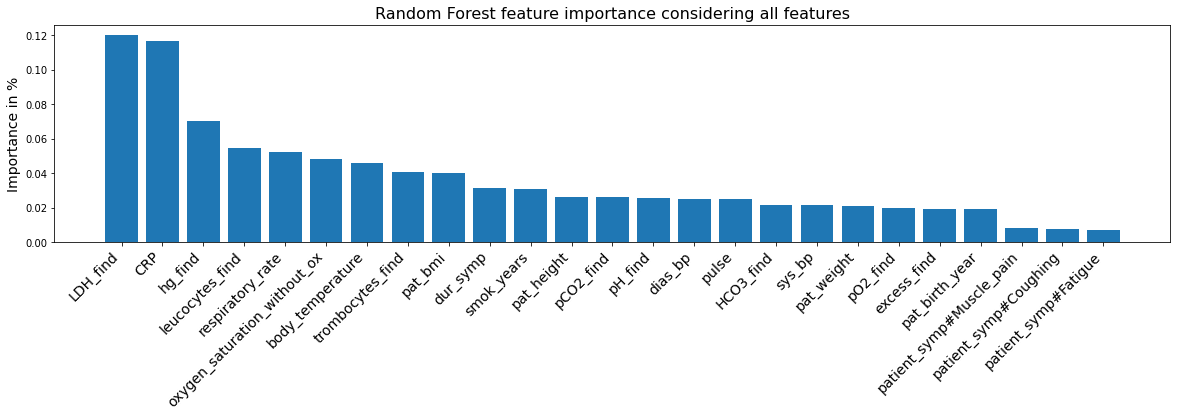

In [28]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
clf.fit(features, label)

x_values = data_training.columns[np.argsort(clf.feature_importances_)][::-1][:25]
y_values = clf.feature_importances_[np.argsort(clf.feature_importances_)][::-1][:25]

fig, ax = plt.subplots(figsize=(20, 4))
bar = ax.bar(x_values, y_values)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_title('Random Forest feature importance considering all features', fontsize=16)
ax.set_ylabel('Importance in %', fontsize=14)
plt.show()

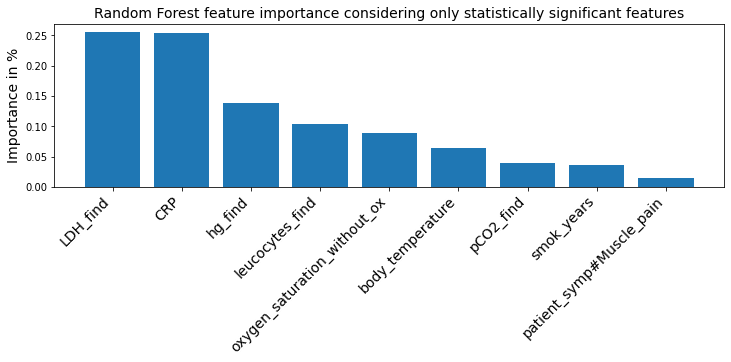

In [29]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
clf.fit(features_sign, label)

x_values = signif_features.columns[np.argsort(clf.feature_importances_)][::-1]
y_values = clf.feature_importances_[np.argsort(clf.feature_importances_)][::-1]

fig, ax = plt.subplots(figsize=(12, 3))
bar = ax.bar(x_values, y_values)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_title('Random Forest feature importance considering only statistically significant features', fontsize=14)
ax.set_ylabel('Importance in %', fontsize=14)
plt.show()

f:\Anaconda\envs\Bachelor_Thesis_V2\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


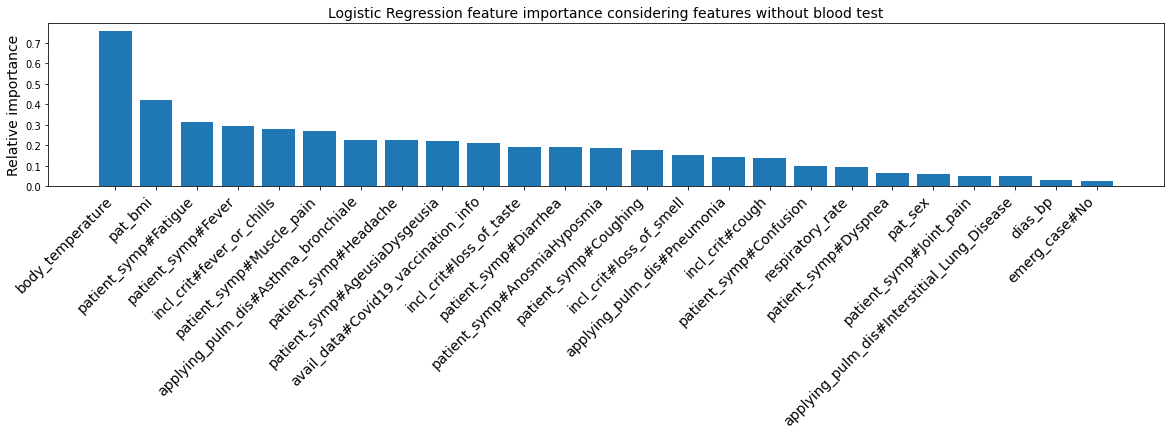

In [30]:
clf = LogisticRegression()
clf.fit(features_no_bt, label)

x_values = data_training.drop(blood_test_features, axis=1).columns[np.argsort(clf.coef_[0])][::-1][:25]
y_values = clf.coef_[0][np.argsort(clf.coef_[0])][::-1][:25]

fig, ax = plt.subplots(figsize=(20, 3))
bar = ax.bar(x_values, y_values)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
ax.set_title('Logistic Regression feature importance considering features without blood test', fontsize=14)
ax.set_ylabel('Relative importance', fontsize=14)
plt.show()

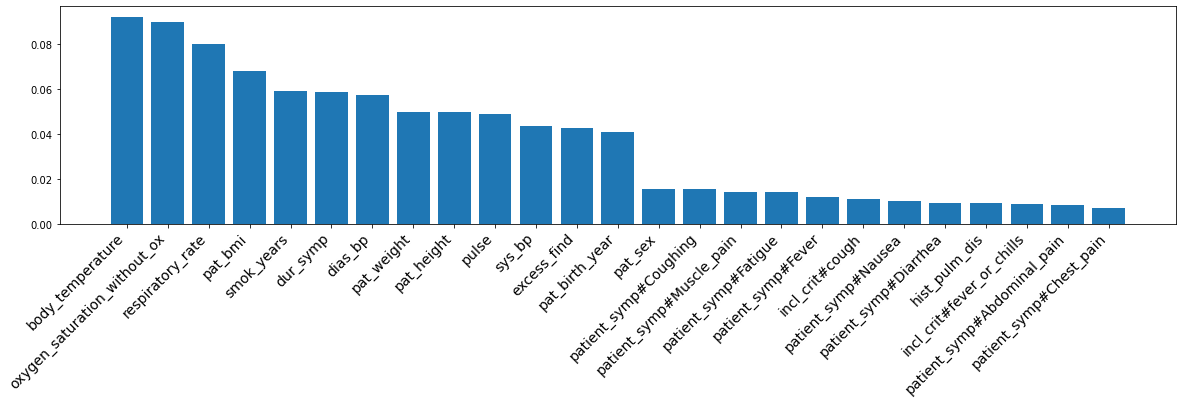

In [27]:
clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=0)
clf.fit(features_no_bt, label)

x_values = data_training.drop(blood_test_features, axis=1).columns[np.argsort(clf.feature_importances_)][::-1][:25]
y_values = clf.feature_importances_[np.argsort(clf.feature_importances_)][::-1][:25]

fig, ax = plt.subplots(figsize=(20, 4))
bar = ax.bar(x_values, y_values)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")
plt.show()